In [1]:
from transformers import AutoModelForPreTraining, AutoTokenizer
from normalizer import normalize # pip install git+https://github.com/csebuetnlp/normalizer
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification
from transformers import AdamW
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.nn import CrossEntropyLoss
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

/home/csgrads/wahid016/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/csgrads/wahid016/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:

# Assuming you already have train.csv, test.csv, and validation.csv loaded as DataFrames
train_data = pd.read_csv("Train.csv")
val_data = pd.read_csv("Val.csv")
test_data = pd.read_csv("Test.csv")

# Rename columns to match expected format
train_data = train_data.rename(columns={"Data": "text", "Label": "label"})
val_data = val_data.rename(columns={"Data": "text", "Label": "label"})
test_data = test_data.rename(columns={"Data": "text", "Label": "label"})

# Convert pandas DataFrames to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

In [ ]:
model = AutoModelForPreTraining.from_pretrained("csebuetnlp/banglabert_large")
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert_large") 

In [4]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
val_dataloader = DataLoader(val_dataset, batch_size=16)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# Set device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Loss function
loss_fn = CrossEntropyLoss()

# Initialize lists to store losses
train_losses = []
val_losses = []


Map: 100%|██████████| 1567/1567 [00:00<00:00, 16812.92 examples/s]
/home/csgrads/wahid016/.local/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train Loss = 0.9501, Validation Loss = 0.7778
Epoch 2: Train Loss = 0.6302, Validation Loss = 0.6690
Epoch 3: Train Loss = 0.2673, Validation Loss = 0.7492
Epoch 4: Train Loss = 0.1657, Validation Loss = 0.8606
Epoch 5: Train Loss = 0.0996, Validation Loss = 1.1216
Epoch 6: Train Loss = 0.0895, Validation Loss = 1.1950
Epoch 7: Train Loss = 0.0852, Validation Loss = 1.1933
Epoch 8: Train Loss = 0.0812, Validation Loss = 1.2097


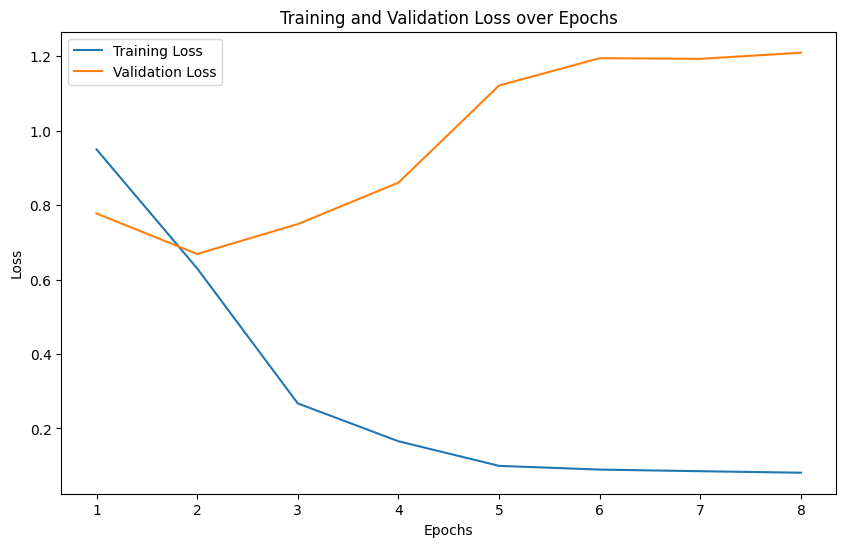

In [5]:
# Training loop
epochs = 8
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()

        # Move data to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        total_train_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()
    scheduler.step()

    # Validation loop
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            # Move data to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            total_val_loss += loss.item()

    # Calculate average losses
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_val_loss = total_val_loss / len(val_dataloader)

    # Store losses for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Validation Loss = {avg_val_loss:.4f}")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()